In [1]:
# Cella 0: Import librerie e configurazioni

# Librerie per manipolazione dati
import pandas as pd
import numpy as np

# Librerie per visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing e modellazione
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, TargetEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

# Statistica e test statistici
from scipy.stats import normaltest, chi2_contingency, probplot, stats

# Utility
from pathlib import Path
import warnings
import logging
import pickle
import json
from datetime import datetime

# Caricamento dati
from data_loader.load_data_2 import load_data_dual_omi

# ===============================
# CONFIGURAZIONI E PARAMETRI
# ===============================

# Paths input
DATA_DIR = Path("data")
SCHEMA_PATH = DATA_DIR / "tabelle_alias_colonne.json"

# Versioning con timestamp
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

# Paths output
OUTPUT_DIR = Path(f"data/{TIMESTAMP}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

TRANSFORMERS_DIR = Path("transformers")
TRANSFORMERS_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_PATH = OUTPUT_DIR / "train.csv"
TEST_PATH = OUTPUT_DIR / "test.csv"
PREPROCESSING_REPORT_PATH = OUTPUT_DIR / "preprocessing_report.json"
TRANSFORMERS_PATH = TRANSFORMERS_DIR / f"{TIMESTAMP}.pkl"

# Parametri del modello
TARGET_COLUMN = 'AI_Prezzo_Ridistribuito'
TEST_SIZE = 0.15
RANDOM_STATE = 42

# Soglie per preprocessing
CRAMER_THRESHOLD = 0.85      # Soglia per rimuovere variabili categoriche correlate
CORR_THRESHOLD = 0.95        # Soglia per correlazione numerica
PCA_VARIANCE_THRESHOLD = 0.95 # Varianza spiegata da mantenere in PCA
LOW_CARDINALITY_THRESHOLD = 20  # Soglia per encoding categoriche
HIGH_CARDINALITY_MAX = 100    # Massima cardinalità per target encoding

# Outlier detection
Z_THRESHOLD = 3.0
IQR_MULTIPLIER = 1.5
ISOLATION_CONTAMINATION = 0.05
MIN_METHODS_OUTLIER = 2  # Numero minimo di metodi che devono identificare un outlier

# Configurazioni generali
warnings.filterwarnings("ignore")

# Setup logging
LOG_DIR = Path(f"log/preprocessing/{TIMESTAMP}")
LOG_DIR.mkdir(parents=True, exist_ok=True)
LOG_FILE_PATH = LOG_DIR / f"{TIMESTAMP}.log"

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(LOG_FILE_PATH),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Configurazioni display pandas per visualizzazione completa
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)

logger.info(f"Configurazioni completate - Timestamp: {TIMESTAMP}")
logger.info(f"Dataset verranno salvati in: {OUTPUT_DIR}")
logger.info(f"Trasformatori verranno salvati in: {TRANSFORMERS_PATH}")


2025-06-27 15:54:51,204 - INFO - Configurazioni completate - Timestamp: 20250627_155451
2025-06-27 15:54:51,205 - INFO - Dataset verranno salvati in: data\20250627_155451
2025-06-27 15:54:51,208 - INFO - Trasformatori verranno salvati in: transformers\20250627_155451.pkl


In [2]:
# Cella 1: Caricamento e validazione dati

def validate_dataset(df, target_column):
    """Valida il dataset caricato"""
    logger.info("Inizio validazione dataset")
    
    # Controlli base
    if df.empty:
        raise ValueError("Dataset vuoto!")
    
    if target_column not in df.columns:
        raise ValueError(f"Target '{target_column}' non trovato nel dataset")
    
    # Informazioni sul dataset
    memory_usage = df.memory_usage(deep=True).sum() / 1024**2
    logger.info(f"Dataset caricato: {df.shape[0]} righe, {df.shape[1]} colonne")
    logger.info(f"Memoria utilizzata: {memory_usage:.2f} MB")
    logger.info(f"Target '{target_column}' trovato")
    
    # Controllo target
    target_nulls = df[target_column].isnull().sum()
    if target_nulls > 0:
        logger.warning(f"Target ha {target_nulls} valori nulli ({target_nulls/len(df)*100:.2f}%)")
    
    return True

# Caricamento dati
logger.info("Caricamento dataset...")
df = load_data_dual_omi(SCHEMA_PATH)
validate_dataset(df, TARGET_COLUMN)
df.info()


2025-06-27 15:54:51,239 - INFO - Caricamento dataset...


Colonne duplicate rimosse: {'AI_DatiCatastaliCompleti', 'ISC_CodAcque', 'ISC_ComAsc1', 'PC_Id', 'II_IdIstatZonaCensuaria', 'AI_FoglioAttuale', 'OZ_Id', 'II_COMUNE', 'ISC_Id', 'AI_IdAtto', 'PC_Foglio', 'ISC_CodMontD', 'ISC_ComAsc2', 'PC_CodiceCatastale', 'PCOZ_IdParticella', 'ISC_CodIsole', 'ISC_CodAreaS', 'OV_IdTipologiaEdilizia_normale', 'AI_SezioneUrbana', 'OV_ValoreLocazioneMax_scadente', 'ISC_ComAsc3', 'A_TotaleFabbricati', 'ISC_CodIsam', 'OV_ValoreLocazioneSup_scadente', 'II_COM_ASC3', 'PC_Particella', 'PC_IdSezioneCensuaria', 'II_COM_ASC2', 'PCOZ_IdZona', 'AI_SezioneCensuaria'}
Elaborazione features del piano...


2025-06-27 15:59:31,483 - INFO - Inizio validazione dataset
2025-06-27 15:59:31,599 - INFO - Dataset caricato: 4275 righe, 231 colonne
2025-06-27 15:59:31,600 - INFO - Memoria utilizzata: 16.07 MB
2025-06-27 15:59:31,601 - INFO - Target 'AI_Prezzo_Ridistribuito' trovato


Features del piano aggiunte: ['floor_min_floor', 'floor_max_floor', 'floor_n_floors', 'floor_has_basement', 'floor_has_ground', 'floor_has_upper', 'floor_floor_span', 'floor_floor_numeric_weighted']
Valori nulli in floor_numeric_weighted: 2125
Range floor_numeric_weighted: -2.00 - 11.00
⚠️ Colonne interamente NaN rimosse: ['AI_SezioneAmministrativa']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4275 entries, 0 to 4274
Columns: 231 entries, A_Id to floor_floor_numeric_weighted
dtypes: bool(4), float64(151), int64(27), object(49)
memory usage: 7.4+ MB


In [3]:
# Cella 2: Rimozione colonne non conoscibili a priori

def remove_non_predictive_columns(df, cols_to_drop):
    """Rimuove colonne che non dovrebbero essere disponibili a priori"""
    logger.info("Rimozione colonne non predittive...")
    
    initial_cols = df.shape[1]
    existing_cols = [col for col in cols_to_drop if col in df.columns]
    
    if existing_cols:
        df.drop(columns=existing_cols, inplace=True)
        logger.info(f"Rimosse {len(existing_cols)} colonne: {existing_cols}")
    else:
        logger.info("Nessuna colonna da rimuovere trovata")
    
    logger.info(f"Colonne: {initial_cols} -> {df.shape[1]}")
    return df

cols_to_drop = ['A_Id', 'A_Codice', 'A_Prezzo', 'AI_Id']
df = remove_non_predictive_columns(df, cols_to_drop)


2025-06-27 15:59:31,642 - INFO - Rimozione colonne non predittive...
2025-06-27 15:59:31,661 - INFO - Rimosse 4 colonne: ['A_Id', 'A_Codice', 'A_Prezzo', 'AI_Id']
2025-06-27 15:59:31,663 - INFO - Colonne: 231 -> 227


In [4]:
# Cella 3: Rimozione colonne costanti e quasi-costanti

def remove_constant_columns(df):
    """Rimuove colonne costanti o quasi-costanti"""
    logger.info("Rimozione colonne costanti...")
    
    initial_cols = df.shape[1]
    nunici = df.nunique(dropna=False)
    costanti = nunici[nunici <= 1].index.tolist()
    
    if costanti:
        df.drop(columns=costanti, inplace=True)
        logger.info(f"Rimosse {len(costanti)} colonne costanti: {costanti}")
    else:
        logger.info("Nessuna colonna costante trovata")
    
    logger.info(f"Colonne: {initial_cols} -> {df.shape[1]}")
    return df, costanti

df, removed_constants = remove_constant_columns(df)


2025-06-27 15:59:31,700 - INFO - Rimozione colonne costanti...
2025-06-27 15:59:31,817 - INFO - Rimosse 18 colonne costanti: ['A_IdConservatoria', 'A_ImmobiliPrincipaliConSuperficieValorizzata', 'AI_IdComune', 'II_CODREG', 'II_REGIONE', 'II_CODPRO', 'II_PROVINCIA', 'II_CODCOM', 'II_PROCOM', 'II_COM_ASC1', 'ISC_CodReg', 'ISC_CodUts', 'ISC_ProCom', 'ISC_CodZic', 'OV_Stato_normale', 'OV_ValoreMercatoSup_normale', 'PC_Sezione', 'PC_PoligonoMetricoSrid']
2025-06-27 15:59:31,818 - INFO - Colonne: 227 -> 209


In [5]:
# Cella 4: Calcolo Cramér's V per categoriche

def cramers_v(x, y):
    """Calcola Cramér's V tra due variabili categoriche"""
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.empty or confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
        return np.nan

    chi2, _, _, _ = chi2_contingency(confusion_matrix, correction=False)
    n = confusion_matrix.values.sum()
    if n == 0:
        return np.nan

    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom > 0 else np.nan

def remove_highly_correlated_categorical(df, threshold=CRAMER_THRESHOLD):
    """Rimuove variabili categoriche altamente correlate usando Cramér's V"""
    logger.info(f"Rimozione variabili categoriche correlate (soglia: {threshold})...")
    
    # Seleziona categoriche "vere"
    cat_cols = df.select_dtypes(include='object').columns
    cat_cols = [col for col in cat_cols if df[col].nunique() > 1]
    
    if len(cat_cols) < 2:
        logger.info("Meno di 2 variabili categoriche, skip correlazione")
        return df, []
    
    logger.info(f"Analisi correlazione su {len(cat_cols)} variabili categoriche")
    
    # Calcola matrice Cramér's V
    cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)
    
    for col1 in cat_cols:
        for col2 in cat_cols:
            if col1 == col2:
                cramer_matrix.loc[col1, col2] = 1.0
            elif pd.isna(cramer_matrix.loc[col1, col2]):
                value = cramers_v(df[col1], df[col2])
                cramer_matrix.loc[col1, col2] = value
                cramer_matrix.loc[col2, col1] = value
    
    # Rimuovi categoriche con Cramér's V > soglia
    to_remove = set()
    for col in cramer_matrix.columns:
        high_corr = cramer_matrix[col][(cramer_matrix[col] > threshold) & (cramer_matrix[col] < 1.0)].index
        for other in high_corr:
            if other not in to_remove:
                to_remove.add(other)
    
    removed_cols = list(to_remove)
    if removed_cols:
        df.drop(columns=removed_cols, inplace=True)
        logger.info(f"Rimosse {len(removed_cols)} variabili categoriche correlate: {removed_cols}")
    else:
        logger.info("Nessuna variabile categorica da rimuovere per correlazione")
    
    return df, removed_cols

df, removed_categorical = remove_highly_correlated_categorical(df)



2025-06-27 15:59:31,864 - INFO - Rimozione variabili categoriche correlate (soglia: 0.85)...
2025-06-27 15:59:31,932 - INFO - Analisi correlazione su 29 variabili categoriche
2025-06-27 15:59:43,747 - INFO - Rimosse 25 variabili categoriche correlate: ['AI_Particella', 'A_IdDecodificaAtto', 'PC_FoglioAgenzia', 'AI_Foglio', 'OV_IdTipologiaEdilizia_ottimo', 'OV_ValoreLocazioneSup_ottimo', 'A_IdTipologiaAtto', 'AI_IdCategoriaCatastale', 'II_Id', 'OV_Id_ottimo', 'OV_ValoreLocazioneSup_normale', 'OV_Id_normale', 'A_IdTipoConsistenza', 'A_Semestre', 'OV_IdZona_normale', 'OZ_LinkZona', 'OV_IdZona_ottimo', 'OV_IdZona_scadente', 'OZ_Zona', 'OV_Id_scadente', 'AI_IdTipologiaEdilizia', 'AI_ParticellaAttuale', 'AI_ConsistenzaUm', 'AI_IdSettoreMercato', 'AI_Via']


In [6]:
# Cella 5: Conversione automatica a numerico

def auto_convert_to_numeric(df):
    """Tenta conversione automatica a numerico per colonne object"""
    logger.info("Conversione automatica a numerico...")
    
    object_cols = df.select_dtypes(include='object').columns
    converted = []
    
    for col in object_cols:
        try:
            original_dtype = df[col].dtype
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if df[col].dtype != original_dtype:
                converted.append(col)
        except:
            continue
    
    if converted:
        logger.info(f"Convertite a numerico {len(converted)} colonne: {converted}")
    else:
        logger.info("Nessuna colonna convertita")
    
    return df, converted

df, converted_cols = auto_convert_to_numeric(df)


2025-06-27 15:59:43,772 - INFO - Conversione automatica a numerico...
2025-06-27 15:59:43,834 - INFO - Convertite a numerico 9 colonne: ['A_VenditoriEredita', 'AI_Subalterno', 'AI_Civico', 'AI_Piano', 'OV_IdTipologiaEdilizia_scadente', 'OV_Stato_ottimo', 'OV_Stato_scadente', 'OV_ValoreMercatoSup_ottimo', 'OV_ValoreMercatoSup_scadente']


In [7]:
# Cella 6: Encoding categoriche avanzato

def advanced_categorical_encoding(df, target_column, low_card_threshold=LOW_CARDINALITY_THRESHOLD, 
                                high_card_max=HIGH_CARDINALITY_MAX):
    """Encoding avanzato per variabili categoriche"""
    logger.info("Encoding variabili categoriche...")
    
    cat_cols = df.select_dtypes(include='object').columns
    cat_cols = [col for col in cat_cols if col != target_column]  # Escludi target se categorico
    
    if len(cat_cols) == 0:
        logger.info("Nessuna variabile categorica da encodare")
        return df, {}
    
    encoding_info = {}
    
    # Separazione per cardinalità
    low_card = [col for col in cat_cols if df[col].nunique() < low_card_threshold]
    high_card = [col for col in cat_cols if df[col].nunique() >= low_card_threshold and df[col].nunique() < high_card_max]
    very_high_card = [col for col in cat_cols if df[col].nunique() >= high_card_max]
    
    logger.info(f"Variabili categoriche - Bassa cardinalità: {len(low_card)}, Alta: {len(high_card)}, Molto alta: {len(very_high_card)}")
    
    # One-hot encoding per bassa cardinalità
    if low_card:
        logger.info(f"One-hot encoding per {len(low_card)} variabili a bassa cardinalità")
        df = pd.get_dummies(df, columns=low_card, drop_first=True)
        encoding_info['one_hot'] = low_card
    
    # Target encoding per alta cardinalità (solo se target è numerico)
    if high_card and df[target_column].dtype in ['int64', 'float64']:
        logger.info(f"Target encoding per {len(high_card)} variabili ad alta cardinalità")
        target_encoders = {}
        
        for col in high_card:
            encoder = TargetEncoder(random_state=RANDOM_STATE)
            df[col] = encoder.fit_transform(df[[col]], df[target_column])
            target_encoders[col] = encoder
        
        encoding_info['target_encoding'] = target_encoders
    
    # Label encoding per cardinalità molto alta (fallback)
    if very_high_card:
        logger.warning(f"Label encoding per {len(very_high_card)} variabili a cardinalità molto alta")
        label_encoders = {}
        
        for col in very_high_card:
            encoder = LabelEncoder()
            df[col] = encoder.fit_transform(df[col].astype(str))
            label_encoders[col] = encoder
        
        encoding_info['label_encoding'] = label_encoders
    
    return df, encoding_info

df, encoding_info = advanced_categorical_encoding(df, TARGET_COLUMN)


2025-06-27 15:59:43,879 - INFO - Encoding variabili categoriche...
2025-06-27 15:59:43,881 - INFO - Nessuna variabile categorica da encodare


In [8]:
# Cella 7: Imputazione dei valori nulli

def impute_missing_values(df, target_column):
    """Imputazione intelligente dei valori mancanti"""
    logger.info("Imputazione valori mancanti...")

    missing_before = df.isnull().sum().sum()
    logger.info(f"Valori mancanti totali: {missing_before}")

    if missing_before == 0:
        logger.info("Nessun valore mancante da imputare")
        return df, {}

    imputers = {}
    skipped = []

    # Numeriche: mediana
    num_cols = df.select_dtypes(include=np.number).columns
    num_cols = [col for col in num_cols if col != target_column]  # Escludi target

    if len(num_cols) > 0:
        missing_num = df[num_cols].isnull().sum()
        cols_with_missing = missing_num[missing_num > 0].index.tolist()

        if cols_with_missing:
            # Filtra solo le colonne con almeno un valore NON nullo
            usable_cols = [col for col in cols_with_missing if df[col].notnull().any()]

            if usable_cols:
                logger.info(f"Imputazione mediana per {len(usable_cols)} colonne numeriche")
                imputer_num = SimpleImputer(strategy='median')
                imputed_data = imputer_num.fit_transform(df[usable_cols])
                df[usable_cols] = pd.DataFrame(imputed_data, columns=usable_cols, index=df.index)
                imputers['numeric'] = imputer_num

            # Colonne completamente NaN
            skipped = list(set(cols_with_missing) - set(usable_cols))
            if skipped:
                logger.warning(f"Colonne numeriche interamente NaN (saltate): {skipped}")

    # Categoriche: "MISSING"
    cat_cols = df.select_dtypes(include='object').columns

    if len(cat_cols) > 0:
        missing_cat = df[cat_cols].isnull().sum()
        cols_with_missing = missing_cat[missing_cat > 0].index.tolist()

        if cols_with_missing:
            logger.info(f"Imputazione 'MISSING' per {len(cols_with_missing)} colonne categoriche")
            for col in cols_with_missing:
                df[col] = df[col].fillna('MISSING')

    # Drop delle colonne numeriche interamente NaN
    if skipped:
        logger.info(f"Droppo {len(skipped)} colonne interamente NaN: {skipped}")
        df.drop(columns=skipped, inplace=True)

    missing_after = df.isnull().sum().sum()
    logger.info(f"Valori mancanti dopo imputazione: {missing_after}")

    return df, imputers

# Esegui la funzione
df, imputers = impute_missing_values(df, TARGET_COLUMN)


2025-06-27 15:59:43,938 - INFO - Imputazione valori mancanti...
2025-06-27 15:59:43,945 - INFO - Valori mancanti totali: 68370
2025-06-27 15:59:43,997 - INFO - Imputazione mediana per 19 colonne numeriche
2025-06-27 15:59:44,079 - WARNING - Colonne numeriche interamente NaN (saltate): ['OV_ValoreMercatoSup_ottimo', 'OV_ValoreMercatoSup_scadente', 'OV_Stato_scadente', 'OV_Stato_ottimo']
2025-06-27 15:59:44,081 - INFO - Droppo 4 colonne interamente NaN: ['OV_ValoreMercatoSup_ottimo', 'OV_ValoreMercatoSup_scadente', 'OV_Stato_scadente', 'OV_Stato_ottimo']
2025-06-27 15:59:44,145 - INFO - Valori mancanti dopo imputazione: 0


In [9]:
# Cella 8: Train/Test Split PRIMA della rimozione outliers

def split_dataset(df, target_column, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    """Divide il dataset in train e test"""
    logger.info(f"Divisione dataset (test_size={test_size})...")
    
    # Separa features e target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=None
    )
    
    logger.info(f"Train set: {X_train.shape[0]} righe")
    logger.info(f"Test set: {X_test.shape[0]} righe")
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(df, TARGET_COLUMN)


2025-06-27 15:59:44,208 - INFO - Divisione dataset (test_size=0.15)...
2025-06-27 15:59:44,238 - INFO - Train set: 3633 righe
2025-06-27 15:59:44,239 - INFO - Test set: 642 righe


In [10]:
# Cella 9: Rimozione feature numeriche altamente correlate (solo su train)

def remove_highly_correlated_numeric(X_train, X_test, threshold=CORR_THRESHOLD):
    """Rimuove feature numeriche altamente correlate"""
    logger.info(f"Rimozione feature numeriche correlate (soglia: {threshold})...")
    
    # Calcola correlazione solo su train
    corr = X_train.select_dtypes(include=np.number).corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    
    if to_drop:
        logger.info(f"Rimosse {len(to_drop)} feature numeriche correlate: {to_drop}")
        X_train = X_train.drop(columns=to_drop)
        X_test = X_test.drop(columns=to_drop)
    else:
        logger.info("Nessuna feature numerica da rimuovere per correlazione")
    
    return X_train, X_test, to_drop

X_train, X_test, removed_numeric = remove_highly_correlated_numeric(X_train, X_test)


2025-06-27 15:59:44,289 - INFO - Rimozione feature numeriche correlate (soglia: 0.95)...
2025-06-27 15:59:44,829 - INFO - Rimosse 82 feature numeriche correlate: ['A_Anno', 'A_Numero', 'AI_Numero', 'II_P2', 'II_P3', 'II_P35', 'II_P37', 'II_P38', 'II_P39', 'II_P40', 'II_P41', 'II_P44', 'II_P45', 'II_P72', 'II_P74', 'II_P75', 'II_P76', 'II_P77', 'II_P78', 'II_P79', 'II_P80', 'II_P81', 'II_P82', 'II_P83', 'II_P84', 'II_P85', 'II_P88', 'II_P89', 'II_P93', 'II_P94', 'II_P95', 'II_P97', 'II_P98', 'II_P99', 'II_P100', 'II_P101', 'II_P102', 'II_P103', 'II_IT2', 'II_IT3', 'II_IT4', 'II_IT5', 'II_IT6', 'II_IT7', 'II_IT8', 'II_IT9', 'II_IT10', 'II_IT11', 'II_IT12', 'II_ST2', 'II_ST2_B', 'II_ST3', 'II_ST4', 'II_ST18', 'II_ST19', 'II_ST20', 'II_ST21', 'II_ST22', 'II_ST23', 'II_ST25', 'II_ST26', 'II_ST28', 'II_ST29', 'II_ST31', 'II_ST32', 'II_PF1', 'II_PF3', 'II_PF4', 'II_PF5', 'II_A2', 'II_A8', 'ISC_Loc21Id', 'ISC_Pop21', 'ISC_Fam21', 'ISC_Abi21', 'ISC_Edi21', 'OV_ValoreMercatoMax_normale', 'OV_Val

In [11]:
# Cella 10: Feature scaling (fit solo su train)

def scale_features(X_train, X_test):
    """Scala le feature usando StandardScaler"""
    logger.info("Scaling delle feature...")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Usa parametri del train
    
    logger.info(f"Feature scalate: {X_train_scaled.shape[1]}")
    
    return X_train_scaled, X_test_scaled, scaler

X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)


2025-06-27 15:59:44,854 - INFO - Scaling delle feature...
2025-06-27 15:59:44,912 - INFO - Feature scalate: 97


2025-06-27 15:59:44,961 - INFO - Trasformazione target e rilevamento outliers...
2025-06-27 15:59:44,968 - INFO - Skewness originale: 5.682
2025-06-27 15:59:44,969 - INFO - Skewness dopo log: -0.725
2025-06-27 15:59:45,341 - INFO - Z-Score (>3.0): 32 outliers (0.88%)
2025-06-27 15:59:45,342 - INFO - IQR (1.5x): 74 outliers (2.04%)
2025-06-27 15:59:45,343 - INFO - Isolation Forest: 182 outliers (5.01%)
2025-06-27 15:59:45,347 - INFO - Combined (≥2 metodi): 36 outliers (0.99%)


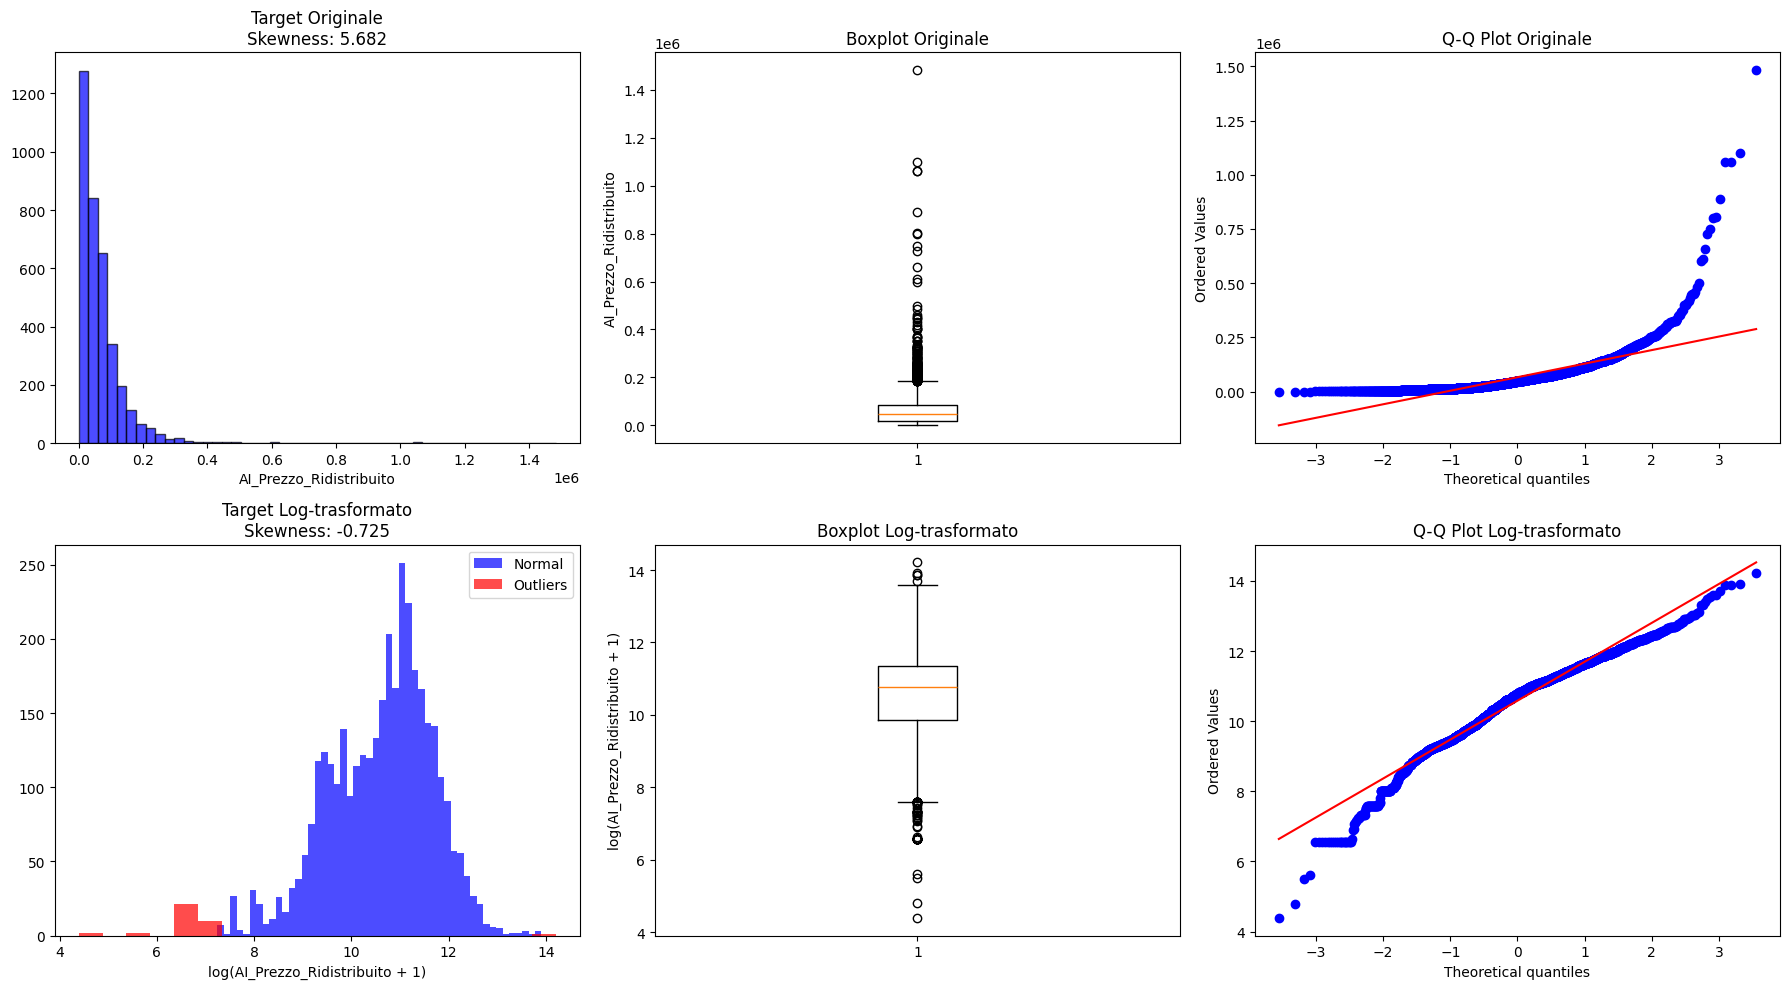

2025-06-27 15:59:46,782 - INFO - Test di Normalità:
2025-06-27 15:59:46,801 - INFO - Target originale - D'Agostino-Pearson p-value: 0.000000
2025-06-27 15:59:46,809 - INFO - Target log-trasformato (senza outliers) - D'Agostino-Pearson p-value: 0.000000
2025-06-27 15:59:46,811 - INFO - Rimozione di 36 outliers dal training set (0.99%)
2025-06-27 15:59:46,823 - INFO - Training set pulito: 3597 righe


In [12]:
# Cella 11: Trasformazione logaritmica + Outlier Detection (solo su train)

def transform_target_and_detect_outliers(y_train, X_train_scaled, 
                                       z_threshold=Z_THRESHOLD, 
                                       iqr_multiplier=IQR_MULTIPLIER,
                                       contamination=ISOLATION_CONTAMINATION,
                                       min_methods=MIN_METHODS_OUTLIER):
    """Trasforma il target e rileva outliers solo sul training set"""
    logger.info("Trasformazione target e rilevamento outliers...")
    
    # Step 1: Trasformazione logaritmica
    original_skew = stats.skew(y_train)
    y_train_log = np.log1p(y_train)
    log_skew = stats.skew(y_train_log)
    
    logger.info(f"Skewness originale: {original_skew:.3f}")
    logger.info(f"Skewness dopo log: {log_skew:.3f}")
    
    # Step 2: Outlier detection
    original_shape = len(y_train_log)
    
    # Metodo 1: Z-Score
    z_scores = stats.zscore(y_train_log)
    z_outliers = np.abs(z_scores) > z_threshold
    
    # Metodo 2: IQR
    Q1 = y_train_log.quantile(0.25)
    Q3 = y_train_log.quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = (y_train_log < (Q1 - iqr_multiplier * IQR)) | (y_train_log > (Q3 + iqr_multiplier * IQR))
    
    # Metodo 3: Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=RANDOM_STATE)
    iso_outliers = iso_forest.fit_predict(X_train_scaled) == -1
    
    # Combina i metodi
    combined_outliers = (z_outliers.astype(int) + iqr_outliers.astype(int) + iso_outliers.astype(int)) >= min_methods
    
    # Log risultati
    logger.info(f"Z-Score (>{z_threshold}): {z_outliers.sum()} outliers ({z_outliers.sum()/len(y_train_log)*100:.2f}%)")
    logger.info(f"IQR ({iqr_multiplier}x): {iqr_outliers.sum()} outliers ({iqr_outliers.sum()/len(y_train_log)*100:.2f}%)")
    logger.info(f"Isolation Forest: {iso_outliers.sum()} outliers ({iso_outliers.sum()/len(y_train_log)*100:.2f}%)")
    logger.info(f"Combined (≥{min_methods} metodi): {combined_outliers.sum()} outliers ({combined_outliers.sum()/len(y_train_log)*100:.2f}%)")
    
    # Visualizzazione
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Row 1: Target originale
    axes[0,0].hist(y_train, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0,0].set_title(f'Target Originale\nSkewness: {original_skew:.3f}')
    axes[0,0].set_xlabel(TARGET_COLUMN)
    
    axes[0,1].boxplot(y_train, vert=True)
    axes[0,1].set_title('Boxplot Originale')
    axes[0,1].set_ylabel(TARGET_COLUMN)
    
    # Q-Q Plot originale
    probplot(y_train, dist="norm", plot=axes[0,2])
    axes[0,2].set_title('Q-Q Plot Originale')
    
    # Row 2: Target log-trasformato con outliers
    axes[1,0].hist(y_train_log[~combined_outliers], bins=50, alpha=0.7, label='Normal', color='blue')
    if combined_outliers.sum() > 0:
        axes[1,0].hist(y_train_log[combined_outliers], bins=20, alpha=0.7, label='Outliers', color='red')
    axes[1,0].set_title(f'Target Log-trasformato\nSkewness: {log_skew:.3f}')
    axes[1,0].set_xlabel(f'log({TARGET_COLUMN} + 1)')
    axes[1,0].legend()
    
    axes[1,1].boxplot(y_train_log, vert=True)
    axes[1,1].set_title('Boxplot Log-trasformato')
    axes[1,1].set_ylabel(f'log({TARGET_COLUMN} + 1)')
    
    # Q-Q Plot log-trasformato
    probplot(y_train_log, dist="norm", plot=axes[1,2])
    axes[1,2].set_title('Q-Q Plot Log-trasformato')
    
    plt.tight_layout()
    plt.show()
    
    # Test di normalità
    logger.info("Test di Normalità:")
    sample_size = min(5000, len(y_train))
    _, p_orig = normaltest(y_train.sample(sample_size, random_state=RANDOM_STATE))
    logger.info(f"Target originale - D'Agostino-Pearson p-value: {p_orig:.6f}")
    
    y_train_log_clean = y_train_log[~combined_outliers]
    if len(y_train_log_clean) > 0:
        sample_size_clean = min(5000, len(y_train_log_clean))
        _, p_log = normaltest(y_train_log_clean.sample(sample_size_clean, random_state=RANDOM_STATE))
        logger.info(f"Target log-trasformato (senza outliers) - D'Agostino-Pearson p-value: {p_log:.6f}")
    
    return y_train_log, combined_outliers, iso_forest

y_train_log, outliers_mask, outlier_detector = transform_target_and_detect_outliers(
    y_train, X_train_scaled
)

# Rimozione outliers dal training set
logger.info(f"Rimozione di {outliers_mask.sum()} outliers dal training set ({outliers_mask.sum()/len(y_train)*100:.2f}%)")

X_train_clean = X_train[~outliers_mask]
X_train_scaled_clean = X_train_scaled[~outliers_mask]
y_train_clean = y_train_log[~outliers_mask]

logger.info(f"Training set pulito: {X_train_clean.shape[0]} righe")

2025-06-27 15:59:46,855 - INFO - Applicazione PCA (varianza target: 0.95)...
2025-06-27 15:59:46,878 - INFO - PCA: 97 -> 42 componenti
2025-06-27 15:59:46,879 - INFO - Varianza spiegata totale: 0.952 (95.2%)
2025-06-27 15:59:46,892 - INFO - Errore di ricostruzione PCA: 0.045598
2025-06-27 15:59:46,894 - INFO - Top 5 feature per ogni componente principale:
2025-06-27 15:59:46,897 - INFO - PC1 (varianza: 0.371): {'II_P1': np.float64(0.16594765882301749), 'II_PF6': np.float64(0.15620854975924375), 'II_P86': np.float64(0.15604553291323792), 'II_P20': np.float64(0.1558662737208586), 'II_P23': np.float64(0.1558346835272844)}
2025-06-27 15:59:46,902 - INFO - PC2 (varianza: 0.074): {'A_DatiCatastaliCompleti': np.float64(0.3476182875328799), 'AI_VisuraParseMutazioniSoggettive': np.float64(0.3472851419725407), 'floor_n_floors': np.float64(0.33192694147460877), 'A_AcquirentiCount': np.float64(0.3184870531351445), 'A_AnnoStipula': np.float64(0.3043520551116423)}
2025-06-27 15:59:46,907 - INFO - PC

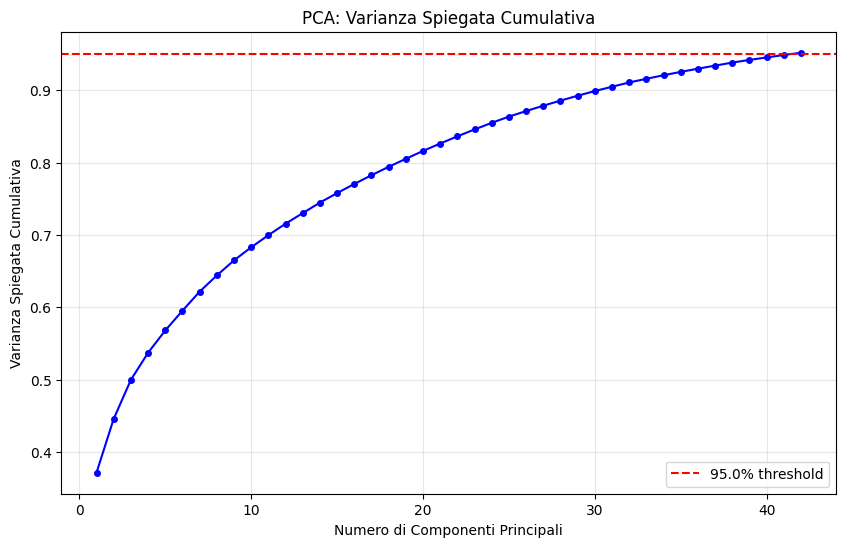

In [13]:
# Cella 12: PCA (fit solo su train pulito)

def apply_pca(X_train_scaled, X_test_scaled, variance_threshold=PCA_VARIANCE_THRESHOLD):
    """Applica PCA mantenendo la varianza specificata"""
    logger.info(f"Applicazione PCA (varianza target: {variance_threshold})...")
    
    pca = PCA(n_components=variance_threshold, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)  # Usa parametri del train
    
    explained_var = pca.explained_variance_ratio_
    
    logger.info(f"PCA: {X_train_scaled.shape[1]} -> {X_train_pca.shape[1]} componenti")
    logger.info(f"Varianza spiegata totale: {explained_var.sum():.3f} ({explained_var.sum()*100:.1f}%)")
    
    # Test di ricostruzione per validare la qualità
    X_reconstructed = pca.inverse_transform(X_train_pca)
    reconstruction_error = np.mean((X_train_scaled - X_reconstructed) ** 2)
    logger.info(f"Errore di ricostruzione PCA: {reconstruction_error:.6f}")
    
    # Loadings per interpretabilità
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train_scaled.shape[1])]
    loadings = pd.DataFrame(
        pca.components_,
        columns=feature_names,
        index=[f'PC{i+1}' for i in range(pca.n_components_)]
    )
    
    # Top feature per ogni componente
    logger.info("Top 5 feature per ogni componente principale:")
    for i in range(pca.n_components_):
        pc_name = f'PC{i+1}'
        top_features = loadings.loc[pc_name].abs().sort_values(ascending=False).head(5)
        logger.info(f"{pc_name} (varianza: {explained_var[i]:.3f}): {dict(top_features)}")
    
    # Grafico varianza cumulativa
    plt.figure(figsize=(10, 6))
    cumvar = np.cumsum(explained_var)
    plt.plot(range(1, len(cumvar) + 1), cumvar, 'bo-', markersize=4)
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{variance_threshold*100}% threshold')
    plt.xlabel('Numero di Componenti Principali')
    plt.ylabel('Varianza Spiegata Cumulativa')
    plt.title('PCA: Varianza Spiegata Cumulativa')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    return X_train_pca, X_test_pca, pca, loadings

X_train_pca, X_test_pca, pca_model, loadings_df = apply_pca(X_train_scaled_clean, X_test_scaled)


In [14]:
# Cella 13: Salvataggio dataset, trasformatori e report di preprocessing

def save_processed_data_and_models(X_train_pca, X_test_pca, y_train_clean, y_test, 
                                   y_train_original, outliers_mask,
                                   scaler, pca_model, outlier_detector, encoding_info, imputers,
                                   removed_constants, removed_categorical, removed_numeric, cols_to_drop,
                                   train_path=TRAIN_PATH, test_path=TEST_PATH,
                                   transformers_path=TRANSFORMERS_PATH,
                                   report_path=PREPROCESSING_REPORT_PATH):
    """Salva dataset processati, trasformatori e report di preprocessing"""
    logger.info("Salvataggio dataset, modelli e report...")

    # Genera nomi per le componenti principali
    pca_cols = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]
    
    # Dataset training
    train_df = pd.DataFrame(X_train_pca, columns=pca_cols)
    train_df['target_log'] = y_train_clean.values
    # Aggiungi target originale (senza outliers)
    train_df['target_original'] = y_train_original.loc[~outliers_mask].values
    
    # Dataset test
    y_test_log = np.log1p(y_test)
    test_df = pd.DataFrame(X_test_pca, columns=pca_cols)
    test_df['target_log'] = y_test_log.values
    # Aggiungi target originale per test
    test_df['target_original'] = y_test.values
    
    # Controllo NaN
    if train_df.isnull().values.any() or test_df.isnull().values.any():
        logger.warning("Attenzione: ci sono valori NaN nei dataset!")
        logger.info(f"NaN nel training set:\n{train_df.isnull().sum()}")
        logger.info(f"NaN nel test set:\n{test_df.isnull().sum()}")
    else:
        logger.info("Nessun NaN nei dataset train/test")
    
    # Salva dataset separati
    train_df.to_csv(train_path, index=False)
    test_df.to_csv(test_path, index=False)
    logger.info(f"Dataset train salvato in: {train_path}")
    logger.info(f"Dataset test salvato in: {test_path}")
    
    # Salva tutti i trasformatori in un unico file
    transformers_to_save = {
        'scaler': scaler,
        'pca_model': pca_model,
        'outlier_detector': outlier_detector,
        'encoding_info': encoding_info,
        'imputers': imputers,
        'timestamp': TIMESTAMP
    }
    
    with open(transformers_path, 'wb') as f:
        pickle.dump(transformers_to_save, f)
    logger.info(f"Trasformatori salvati in: {transformers_path}")
    
    # Salva report di preprocessing
    preprocessing_report = {
        'timestamp': datetime.now().isoformat(),
        'version': TIMESTAMP,
        'dataset_info': {
            'original_shape': [len(y_train_original) + len(y_test), X_train_pca.shape[1] + len(pca_cols)],
            'final_train_shape': list(train_df.shape),
            'final_test_shape': list(test_df.shape),
            'target_column': TARGET_COLUMN
        },
        'preprocessing_steps': {
            'removed_columns': {
                'constants': removed_constants,
                'categorical_high_corr': removed_categorical,
                'numeric_high_corr': removed_numeric,
                'non_predictive': cols_to_drop
            },
            'outliers_removed': int(outliers_mask.sum()),
            'outliers_percentage': float(outliers_mask.sum() / len(outliers_mask) * 100),
            'encoding_applied': list(encoding_info.keys()) if encoding_info else [],
            'imputation_applied': list(imputers.keys()) if imputers else []
        },
        'transformations': {
            'target_log_transformed': True,
            'features_standardized': True,
            'pca_applied': True,
            'pca_components': int(pca_model.n_components_),
            'pca_variance_explained': float(pca_model.explained_variance_ratio_.sum())
        },
        'parameters_used': {
            'test_size': TEST_SIZE,
            'random_state': RANDOM_STATE,
            'cramer_threshold': CRAMER_THRESHOLD,
            'corr_threshold': CORR_THRESHOLD,
            'pca_variance_threshold': PCA_VARIANCE_THRESHOLD,
            'z_threshold': Z_THRESHOLD,
            'iqr_multiplier': IQR_MULTIPLIER,
            'isolation_contamination': ISOLATION_CONTAMINATION,
            'min_methods_outlier': MIN_METHODS_OUTLIER
        },
        'file_paths': {
            'train_data': str(train_path),
            'test_data': str(test_path),
            'transformers': str(transformers_path),
            'report': str(report_path)
        }
    }
    
    # Salva report come JSON
    with open(report_path, 'w') as f:
        json.dump(preprocessing_report, f, indent=2)
    logger.info(f"Report di preprocessing salvato in: {report_path}")
    
    # Stampa summary
    logger.info("=" * 50)
    logger.info("SUMMARY PREPROCESSING COMPLETATO")
    logger.info("=" * 50)
    logger.info(f"Dataset originale: {preprocessing_report['dataset_info']['original_shape']}")
    logger.info(f"Dataset finale train: {preprocessing_report['dataset_info']['final_train_shape']}")
    logger.info(f"Dataset finale test: {preprocessing_report['dataset_info']['final_test_shape']}")
    logger.info(f"Outliers rimossi: {preprocessing_report['preprocessing_steps']['outliers_removed']} ({preprocessing_report['preprocessing_steps']['outliers_percentage']:.2f}%)")
    logger.info(f"Componenti PCA: {preprocessing_report['transformations']['pca_components']}")
    logger.info(f"Varianza spiegata PCA: {preprocessing_report['transformations']['pca_variance_explained']:.3f}")
    logger.info(f"Timestamp versione: {TIMESTAMP}")
    logger.info("=" * 50)
    
    return preprocessing_report

# Chiamata finale
preprocessing_report = save_processed_data_and_models(
    X_train_pca, X_test_pca, y_train_clean, y_test, 
    y_train, outliers_mask,
    scaler, pca_model, outlier_detector, encoding_info, imputers,
    removed_constants, removed_categorical, removed_numeric, cols_to_drop
)

2025-06-27 15:59:47,362 - INFO - Salvataggio dataset, modelli e report...
2025-06-27 15:59:47,381 - INFO - Nessun NaN nei dataset train/test
2025-06-27 15:59:48,113 - INFO - Dataset train salvato in: data\20250627_155451\train.csv
2025-06-27 15:59:48,114 - INFO - Dataset test salvato in: data\20250627_155451\test.csv
2025-06-27 15:59:48,131 - INFO - Trasformatori salvati in: transformers\20250627_155451.pkl
2025-06-27 15:59:48,138 - INFO - Report di preprocessing salvato in: data\20250627_155451\preprocessing_report.json
2025-06-27 15:59:48,143 - INFO - ==================================================
2025-06-27 15:59:48,145 - INFO - SUMMARY PREPROCESSING COMPLETATO
2025-06-27 15:59:48,147 - INFO - ==================================================
2025-06-27 15:59:48,151 - INFO - Dataset originale: [4275, 84]
2025-06-27 15:59:48,163 - INFO - Dataset finale train: [3597, 44]
2025-06-27 15:59:48,165 - INFO - Dataset finale test: [642, 44]
2025-06-27 15:59:48,167 - INFO - Outliers rimo